In [4]:
import sys

sys.path.append('../model_generator')
sys.path.append('../patient_sample_generator')
sys.path.append('../ebm')
sys.path.append('../old_model_generator')
sys.path.append('../ebm')

from model_generator.model_factory import ModelFactory
from patient_sample_generator.sample_generator import SampleGenerator
from ebm.ebm_transformer import EBMModel

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import norm, spearmanr, kendalltau


# Get the absolute path of the current notebook


#from ..model_generator.model_factory import ModelFactory
from old_model_generator.canonical_generator import CanonicalGenerator
from old_model_generator.sample_generator import SampleGenerator

from ebm.probability import log_distributions, fit_distributions
from ebm.mcmc import greedy_ascent, mcmc
from ebm.likelihood import EventProbabilities

In [5]:
def run_ebm(X, y, prior = None, random_state = 1):
    
    log_p_e, log_p_not_e = log_distributions(X, y, point_proba=False)
    
    rng = np.random.RandomState(random_state)
    ideal_order = np.arange(X.shape[1])
    # ditching np.shuffle due to lack of ability to assign randomized starting-order to variable
    starting_order = rng.choice(ideal_order, len(ideal_order), replace=False)
    starting_order_copy = starting_order.copy()
     
    order, loglike, update_iters = greedy_ascent(log_p_e, log_p_not_e, 
                                                n_iter=10_000, order = starting_order,
                                                prior=prior,
                                                random_state=random_state)
    
    greedy_loglike = loglike
    greedy_order = order.copy()
    orders, loglike, update_iters, probas = mcmc(log_p_e, log_p_not_e,
                                                 order=order, n_iter=500_000,
                                                 prior = prior,
                                                 random_state=random_state)
    
    if len(orders) != 0:
        best_order_idx = np.argmax(loglike)
        best_order = orders[best_order_idx]
        best_order = best_order.copy()
    if len(orders) == 0:
        print("Warning: MCMC did not accept new orders, returning greedy ascent result.")
        best_order = order
    
    ## statistical calculations
    
    num_iters = len(orders)
    
    starting_spearmanr, _ = spearmanr(ideal_order, starting_order_copy)
    greedy_spearmanr, _ = spearmanr(ideal_order, greedy_order)
    best_spearmanr, _ = spearmanr(ideal_order, best_order)

    starting_kendalltau, _ = kendalltau(ideal_order, starting_order_copy)
    greedy_kendalltau, _ = kendalltau(ideal_order, greedy_order)
    best_kendalltau, _ = kendalltau(ideal_order, best_order)
    
    ## results dict
    
    results = {
        'starting_order': starting_order_copy,
        'greedy_order': greedy_order,
        'best_order': best_order,
        'starting_spearmanr': starting_spearmanr,
        'greedy_spearmanr': greedy_spearmanr,
        'best_spearmanr': best_spearmanr,        
        'starting_kendalltau': starting_kendalltau,
        'greedy_kendalltau': greedy_kendalltau,
        'best_kendalltau': best_kendalltau,
        'num_iters': num_iters
    }
    
    return results

def run_multiple_ebm(X, y, prior = None, n_trials = 10, csv_filename = 'name.csv'):
    results_list = []

    for trial in range(n_trials):
        result = run_ebm(X, y, prior, random_state=trial)
        results_list.append({
            'run': trial,
            'starting_order': result['starting_order'].tolist(),
            'greedy_order': result['greedy_order'].tolist(),
            'best_order': result['best_order'].tolist(),
            'starting_spearmanr': result['starting_spearmanr'],
            'greedy_spearmanr': result['greedy_spearmanr'],
            'best_spearmanr': result['best_spearmanr'],
            'starting_kendalltau': result['starting_kendalltau'],
            'greedy_kendalltau': result['greedy_kendalltau'],
            'best_kendalltau': result['best_kendalltau']
        })
    
    df = pd.DataFrame(results_list)
    df.to_csv(csv_filename, index=False)
    return df

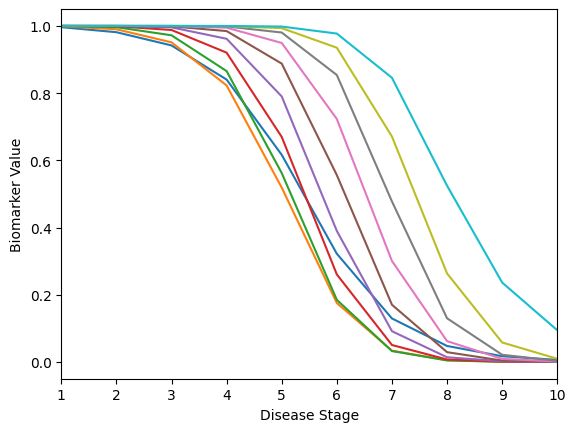

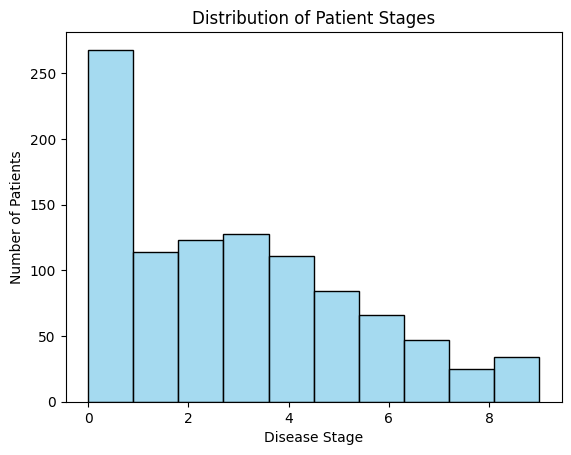

100%|██████████| 500000/500000 [02:25<00:00, 3439.07it/s]


100%|██████████| 500000/500000 [02:24<00:00, 3457.80it/s]


100%|██████████| 500000/500000 [02:28<00:00, 3358.24it/s]


100%|██████████| 500000/500000 [02:24<00:00, 3459.61it/s]


100%|██████████| 500000/500000 [02:24<00:00, 3458.16it/s]


100%|██████████| 500000/500000 [02:22<00:00, 3520.70it/s]


100%|██████████| 500000/500000 [02:22<00:00, 3513.75it/s]


100%|██████████| 500000/500000 [02:26<00:00, 3424.34it/s]


100%|██████████| 500000/500000 [02:28<00:00, 3375.88it/s]


100%|██████████| 500000/500000 [02:23<00:00, 3489.57it/s]


100%|██████████| 500000/500000 [02:25<00:00, 3441.16it/s]


100%|██████████| 500000/500000 [02:23<00:00, 3492.77it/s]


100%|██████████| 500000/500000 [02:23<00:00, 3490.21it/s]


100%|██████████| 500000/500000 [02:25<00:00, 3435.19it/s]


100%|██████████| 500000/500000 [02:21<00:00, 3525.96it/s]


100%|██████████| 500000/500000 [02:22<00:00, 3500.01it/s]


100%|██████████| 500000/500000 [02:22<00:00, 3514.54it/s]


100%|██████████| 500000/500000 [02:21<00:00, 3521.49it/s]


100%|██████████| 500000/500000 [02:22<00:00, 3504.37it/s]


100%|██████████| 500000/500000 [02:23<00:00, 3484.34it/s]


100%|██████████| 500000/500000 [02:28<00:00, 3370.82it/s]


100%|██████████| 500000/500000 [02:27<00:00, 3391.18it/s]


100%|██████████| 500000/500000 [02:26<00:00, 3406.40it/s]


100%|██████████| 500000/500000 [02:27<00:00, 3389.26it/s]


100%|██████████| 500000/500000 [02:26<00:00, 3422.53it/s]


100%|██████████| 500000/500000 [02:26<00:00, 3422.00it/s]


100%|██████████| 500000/500000 [02:27<00:00, 3397.41it/s]


100%|██████████| 500000/500000 [02:26<00:00, 3406.26it/s]


100%|██████████| 500000/500000 [02:28<00:00, 3358.82it/s]


100%|██████████| 500000/500000 [02:24<00:00, 3458.71it/s]


100%|██████████| 500000/500000 [02:25<00:00, 3425.70it/s]


100%|██████████| 500000/500000 [02:25<00:00, 3444.77it/s]


100%|██████████| 500000/500000 [02:25<00:00, 3444.39it/s]


100%|██████████| 500000/500000 [02:25<00:00, 3446.41it/s]


100%|██████████| 500000/500000 [02:26<00:00, 3415.42it/s]


100%|██████████| 500000/500000 [02:25<00:00, 3430.54it/s]


100%|██████████| 500000/500000 [02:25<00:00, 3435.77it/s]


100%|██████████| 500000/500000 [02:25<00:00, 3424.67it/s]


100%|██████████| 500000/500000 [02:25<00:00, 3429.55it/s]


100%|██████████| 500000/500000 [02:26<00:00, 3415.34it/s]

In [6]:
params = {
    'n_stages': 10,  # Number of biomarkers
    'step': 0.1,
    'n_steps': 100,
    'start_time': 0,
    'end_time': 100,
    'steps': 100,
    'connectivity_matrix_type': 'random_connectivity',  # Connectivity matrix type
    'convergence_threshold': 1e-4,
    'flip_v': True
}

model = ModelFactory.create_model('logistic', **params)
model.fit()
prior = model.get_connectivity_matrix()
model.plot()
stage_values = model.transform(X=None) 

sample = SampleGenerator(stage_values=stage_values, 
                         n_patients=1000,
                         distribution=norm,
                         dist_params = {'loc':2.5, 'scale':3.5, 'random_state':10},
                         add_noise=True,
                         noise_std=0.1,
                         random_state=2)

sample.plot_stage_histogram()


X = sample.get_X()
y = sample.get_y()

#run_multiple_ebm(X=X, y=y, csv_filename="transition_results.csv");

prior = model.get_connectivity_matrix()
run_multiple_ebm(X=X, y=y, n_trials=20, prior=None, csv_filename=f"logistic_results_n{sample.n_patients}.csv");
run_multiple_ebm(X=X, y=y, n_trials=20, prior=prior, csv_filename=f"logistic_results_prior_n{sample.n_patients}.csv");

In [7]:
params = {
    'n_stages': 10,  # Number of biomarkers
    'step': 0.1,
    'n_steps': 100,
    'start_time': 0,
    'end_time': 100,
    'steps': 100,
    'connectivity_matrix_type': 'random_connectivity',  # Connectivity matrix type
    'convergence_threshold': 1e-4,
    'flip_v': True
}

model = ModelFactory.create_model('logistic', **params)
model.fit()
prior = model.get_connectivity_matrix()
stage_values = model.transform(X=None)

sample = SampleGenerator(stage_values=stage_values, 
                         n_patients=500,
                         distribution=norm,
                         dist_params = {'loc':2.5, 'scale':3.5, 'random_state':10},
                         add_noise=True,
                         noise_std=0.1,
                         random_state=2)

X = sample.get_X()
y = sample.get_y()

prior = model.get_connectivity_matrix()
run_multiple_ebm(X=X, y=y, n_trials=20, prior=None, csv_filename=f"logistic_results_n{sample.n_patients}.csv");
run_multiple_ebm(X=X, y=y, n_trials=20, prior=prior, csv_filename=f"logistic_results_prior_n{sample.n_patients}.csv");

100%|██████████| 500000/500000 [01:21<00:00, 6136.23it/s]


100%|██████████| 500000/500000 [01:21<00:00, 6143.22it/s]


100%|██████████| 500000/500000 [01:21<00:00, 6168.81it/s]


100%|██████████| 500000/500000 [01:20<00:00, 6186.41it/s]


100%|██████████| 500000/500000 [01:23<00:00, 5967.79it/s]


100%|██████████| 500000/500000 [01:21<00:00, 6140.78it/s]


100%|██████████| 500000/500000 [01:23<00:00, 5962.30it/s]


100%|██████████| 500000/500000 [01:21<00:00, 6142.02it/s]


100%|██████████| 500000/500000 [01:21<00:00, 6122.86it/s]


100%|██████████| 500000/500000 [01:21<00:00, 6144.65it/s]


100%|██████████| 500000/500000 [01:21<00:00, 6102.83it/s]


100%|██████████| 500000/500000 [01:21<00:00, 6099.68it/s]


100%|██████████| 500000/500000 [01:21<00:00, 6143.86it/s]


100%|██████████| 500000/500000 [01:21<00:00, 6154.70it/s]


100%|██████████| 500000/500000 [01:21<00:00, 6133.33it/s]


100%|██████████| 500000/500000 [01:21<00:00, 6118.33it/s]


100%|██████████| 500000/500000 [01:21<00:00, 6132.66it/s]


100%|██████████| 500000/500000 [01:21<00:00, 6118.11it/s]


100%|██████████| 500000/500000 [01:22<00:00, 6026.25it/s]


100%|██████████| 500000/500000 [01:21<00:00, 6146.72it/s]


100%|██████████| 500000/500000 [01:25<00:00, 5833.59it/s]


100%|██████████| 500000/500000 [01:27<00:00, 5735.00it/s]


100%|██████████| 500000/500000 [01:27<00:00, 5741.34it/s]


100%|██████████| 500000/500000 [01:27<00:00, 5725.62it/s]


100%|██████████| 500000/500000 [01:26<00:00, 5763.23it/s]


100%|██████████| 500000/500000 [01:26<00:00, 5770.61it/s]


100%|██████████| 500000/500000 [01:26<00:00, 5761.07it/s]


100%|██████████| 500000/500000 [01:26<00:00, 5773.33it/s]


100%|██████████| 500000/500000 [01:26<00:00, 5764.14it/s]


100%|██████████| 500000/500000 [01:26<00:00, 5805.15it/s]


100%|██████████| 500000/500000 [01:25<00:00, 5819.87it/s]


100%|██████████| 500000/500000 [01:26<00:00, 5759.90it/s]


100%|██████████| 500000/500000 [01:26<00:00, 5772.53it/s]


100%|██████████| 500000/500000 [01:27<00:00, 5746.06it/s]


100%|██████████| 500000/500000 [01:26<00:00, 5791.68it/s]


100%|██████████| 500000/500000 [01:24<00:00, 5899.94it/s]


100%|██████████| 500000/500000 [01:25<00:00, 5863.02it/s]


100%|██████████| 500000/500000 [01:25<00:00, 5829.41it/s]


100%|██████████| 500000/500000 [01:26<00:00, 5747.54it/s]


100%|██████████| 500000/500000 [01:26<00:00, 5807.90it/s]

In [8]:
params = {
    'n_stages': 10,  # Number of biomarkers
    'step': 0.1,
    'n_steps': 100,
    'start_time': 0,
    'end_time': 100,
    'steps': 100,
    'connectivity_matrix_type': 'random_connectivity',  # Connectivity matrix type
    'convergence_threshold': 1e-4,
    'flip_v': True
}

model = ModelFactory.create_model('logistic', **params)
model.fit()
prior = model.get_connectivity_matrix()
stage_values = model.transform(X=None)
 
sample = SampleGenerator(stage_values=stage_values, 
                         n_patients=200,
                         distribution=norm,
                         dist_params = {'loc':2.5, 'scale':3.5, 'random_state':10},
                         add_noise=True,
                         noise_std=0.1,
                         random_state=2)

X = sample.get_X()
y = sample.get_y()

prior = model.get_connectivity_matrix()
run_multiple_ebm(X=X, y=y, n_trials=20, prior=None, csv_filename=f"logistic_results_n{sample.n_patients}.csv");
run_multiple_ebm(X=X, y=y, n_trials=20, prior=prior, csv_filename=f"logistic_results_prior_n{sample.n_patients}.csv");

100%|██████████| 500000/500000 [00:50<00:00, 9894.39it/s] 


In [9]:
params = {
    'n_stages': 10,  # Number of biomarkers
    'step': 0.1,
    'n_steps': 100,
    'start_time': 0,
    'end_time': 100,
    'steps': 100,
    'connectivity_matrix_type': 'random_connectivity',  # Connectivity matrix type
    'convergence_threshold': 1e-4,
    'flip_v': True
}

model = ModelFactory.create_model('logistic', **params)
model.fit()
prior = model.get_connectivity_matrix()
stage_values = model.transform(X=None)

sample = SampleGenerator(stage_values=stage_values, 
                         n_patients=100,
                         distribution=norm,
                         dist_params = {'loc':2.5, 'scale':3.5, 'random_state':10},
                         add_noise=True,
                         noise_std=0.1,
                         random_state=2)

X = sample.get_X()
y = sample.get_y()

prior = model.get_connectivity_matrix()
run_multiple_ebm(X=X, y=y, n_trials=20, prior=None, csv_filename=f"logistic_results_n{sample.n_patients}.csv");
run_multiple_ebm(X=X, y=y, n_trials=20, prior=prior, csv_filename=f"logistic_results_prior_n{sample.n_patients}.csv");

100%|██████████| 500000/500000 [00:34<00:00, 14694.09it/s]
